In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# for t-test precip. mean
from scipy.stats import ttest_ind

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# set fonts configuration - Arial
matplotlib.rcParams['font.family'] = "Open Sans"
matplotlib.rcParams['font.sans-serif'] = "Arial"

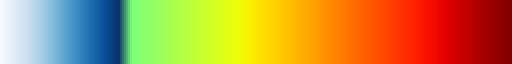

In [4]:
colors1 = plt.cm.Blues(np.linspace(0., 1, 10))
colors2 = plt.cm.jet(np.linspace(0.5, 1, 30))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mixedmap = LinearSegmentedColormap.from_list('my_colormap', colors)
mixedmap

In [5]:
year = 2014

dir_mcs_track = Path('/neelin2020/mcs_flextrkr/mcs_stats/')
dir_mask = Path('/neelin2020/mcs_flextrkr/{}0101.0000_{}0101.0000'.format(year,year+1))
dir_buoy = Path('/neelin2020/ERA-5_buoy/layer_thetae')

In [6]:
# get processed non2mcs tracks over Indo-Pacific with time indices recorded
data_non2mcs_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.IndoPacific.nc'.format(year))

In [17]:
def BL_mcs_2dmap(data, idt_phase):
    """
    input: datetime at a given MCS phase
    idt_phase: index of times in the track that corresponding to the MCS phase
    return BL componets within the tracked MCS feature
    """
    
    mcstracknumber = data.tracks.values

    timestamp_phase = str(data.base_time.isel(times=idt_phase).values)
    year = timestamp_phase[:4]
    month = timestamp_phase[5:7]
    day = timestamp_phase[8:10]
    hour = timestamp_phase[11:13]

    data_mcsmask = xr.open_dataset(dir_mask / 'mcstrack_{}{}{}_{}30.nc'.format(year,month,day,hour))
    data_mcsmask = data_mcsmask.sel(lat=slice(-35,35)) # match buoyancy latitude range (35S-35N)
    lon_reset = data_mcsmask.lon
    lon_reset = lon_reset.where(lon_reset >= 0, 360+lon_reset) # converting lon as 0 to 359.75
    data_mcsmask.coords['lon'] = lon_reset 
    data_mcsmask= data_mcsmask.sortby('lon')    

    # === calculate the regridded BL components from layer thetae values ===
    mcs_mask = data_mcsmask.cloudtracknumber_nomergesplit.drop('time')
    BUOY_data = xr.open_dataset('/neelin2020/ERA-5_buoy/layer_thetae/era5_2layers_thetae_{}_{}_{}.nc'.format(year,month,day))
    BUOY_data = BUOY_data.sel(time=datetime(int(year),int(month),int(day),int(hour)), method='nearest').drop('time')
    
    if len(BUOY_data.keys()) == 5: # if variables are not missing
    
        BUOY_regrid = BUOY_data.interp(lon=data_mcsmask.lon, lat=data_mcsmask.lat)

        thetae_bl = BUOY_regrid.thetae_bl
        thetae_sat_lt = BUOY_regrid.thetae_sat_lt
        thetae_lt = BUOY_regrid.thetae_lt

        delta_pl=400
        delta_pb=100
        wb=(delta_pb/delta_pl)*np.log((delta_pl+delta_pb)/delta_pb)
        wl=1-wb

        BL_CAPE = ((thetae_bl-thetae_sat_lt)/thetae_sat_lt)*340
        BL_SUBSAT = ((thetae_sat_lt-thetae_lt)/thetae_sat_lt)*340
        BL_TOT = (9.81/(340*3))*((wb*BL_CAPE)-(wl*BL_SUBSAT))
        # ==============

        # maskout non-associated grids
        BL_CAPE_mask = BL_CAPE.where(mcs_mask == mcstracknumber + 1) # NOTE: the mcs number using for the mask = tracknumber + 1
        BL_SUBSAT_mask = BL_SUBSAT.where(mcs_mask == mcstracknumber + 1)
        BL_TOT_mask = BL_TOT.where(mcs_mask == mcstracknumber + 1)

        return BL_TOT_mask, BL_CAPE_mask, BL_SUBSAT_mask    

    else:
        print('error file: era5_2layers_thetae_{}_{}_{}.nc'.format(year,month,day))
        
        return np.array([0])

In [ ]:
# mcstracknumber = data.tracks.values

# timestamp_phase = str(data.base_time.isel(times=idt_phase).values)
# year = timestamp_phase[:4]
# month = timestamp_phase[5:7]
# day = timestamp_phase[8:10]
# hour = timestamp_phase[11:13]

# data_mcsmask = xr.open_dataset(dir_mask / 'mcstrack_{}{}{}_{}30.nc'.format(year,month,day,hour))
# data_mcsmask = data_mcsmask.sel(lat=slice(-35,35)) # match buoyancy latitude range (35S-35N)
# lon_reset = data_mcsmask.lon
# lon_reset = lon_reset.where(lon_reset >= 0, 360+lon_reset) # converting lon as 0 to 359.75
# data_mcsmask.coords['lon'] = lon_reset 
# data_mcsmask= data_mcsmask.sortby('lon')    

# # === calculate the regridded BL components from layer thetae values ===
# mcs_mask = data_mcsmask.cloudtracknumber.drop('time')
# BUOY_data = xr.open_dataset('/neelin2020/ERA-5_buoy/layer_thetae/era5_2layers_thetae_{}_{}_{}.nc'.format(year,month,day))
# BUOY_data = BUOY_data.sel(time=datetime(int(year),int(month),int(day),int(hour)), method='nearest').drop('time')
# BUOY_regrid = BUOY_data.interp(lon=data_mcsmask.lon, lat=data_mcsmask.lat)

# thetae_bl = BUOY_regrid.thetae_bl
# thetae_sat_lt = BUOY_regrid.thetae_sat_lt
# thetae_lt = BUOY_regrid.thetae_lt

In [18]:
%%time

# bins for BL_CAPE and BL_SUBSAT

bins_cape = np.linspace(-2,10,25)
bins_subsat = np.linspace(-2,10,25)
bins_samples = np.zeros((5, len(bins_cape)-1, len(bins_subsat)-1)) # histograms for 5 MCS phases

for track_number in data_non2mcs_track.tracks.values:
    
    #print('processing track number: {}'.format(track_number))
    data = data_non2mcs_track.sel(tracks=track_number)
    
    # get time indices for defined MCS phases
    phase_list = [data.idt_mcs_init, data.idt_mcs_grow, data.idt_mcs_mature,data.idt_mcs_decay, data.idt_mcs_end]
    
    # call BL_calc function 
    for p, idt_phase in enumerate(phase_list):
        
        output = BL_mcs_2dmap(data, idt_phase)
        
        if len(output) == 3: # correct output
            
            BL_TOT = output[0]
            BL_CAPE = output[1]
            BL_SUBSAT = output[2]

            # get 1-D CAPE and SUBSAT values associated with MCS
            cape_1d = np.unique(BL_CAPE)[:-1] # the last one is NaN
            subsat_1d = np.unique(BL_SUBSAT)[:-1] # the last one is NaN 

            for i in range(len(bins_cape)-1):
                idx = np.where(np.logical_and(cape_1d >= bins_cape[i], cape_1d < bins_cape[i+1]))[0]
                for j in range(len(bins_subsat)-1):
                    idy = np.where(np.logical_and(subsat_1d >= bins_subsat[j], subsat_1d < bins_subsat[j+1]))[0]

                    idx_com = np.intersect1d(idx,idy)
                    bins_samples[p,i,j] += len(idx_com)

error file: era5_2layers_thetae_2014_01_06.nc
error file: era5_2layers_thetae_2014_01_06.nc
error file: era5_2layers_thetae_2014_01_06.nc
error file: era5_2layers_thetae_2014_01_06.nc
error file: era5_2layers_thetae_2014_01_06.nc
error file: era5_2layers_thetae_2014_01_06.nc
error file: era5_2layers_thetae_2014_01_06.nc
error file: era5_2layers_thetae_2014_01_06.nc
error file: era5_2layers_thetae_2014_01_06.nc
error file: era5_2layers_thetae_2014_01_06.nc
error file: era5_2layers_thetae_2014_01_06.nc
error file: era5_2layers_thetae_2014_01_06.nc
error file: era5_2layers_thetae_2014_01_06.nc
error file: era5_2layers_thetae_2014_01_06.nc
error file: era5_2layers_thetae_2014_01_06.nc
error file: era5_2layers_thetae_2014_01_06.nc
error file: era5_2layers_thetae_2014_01_06.nc
error file: era5_2layers_thetae_2014_01_06.nc
error file: era5_2layers_thetae_2014_01_06.nc
error file: era5_2layers_thetae_2014_01_06.nc
error file: era5_2layers_thetae_2014_01_06.nc
error file: era5_2layers_thetae_20

In [19]:
# save bins into netcdf
dir_out = Path('/neelin2020/mcs_flextrkr/mcs_stats/output_stats')
ds_bins = xr.Dataset(data_vars = dict(samples = (['phase','bins_cape','bins_subsat'], bins_samples)),
                     coords = dict(phase = (['phase'], ['Initial', 'Grow', 'Mature', 'Decay', 'End']),
                                   bins_cape = (['bins_cape'], bins_cape[:-1]),
                                   bins_subsat = (['bins_subsat'], bins_subsat[:-1])),
                     attrs = dict(description = 'cape-subsat histogram. 2014'))
ds_bins.to_netcdf(dir_out / 'mcs_cape_subsat_histogram_IndoPacific.nc')

Text(0.5, 1.05, 'Buoyancy CAPE-SUBSAT histogram at MCS phases')

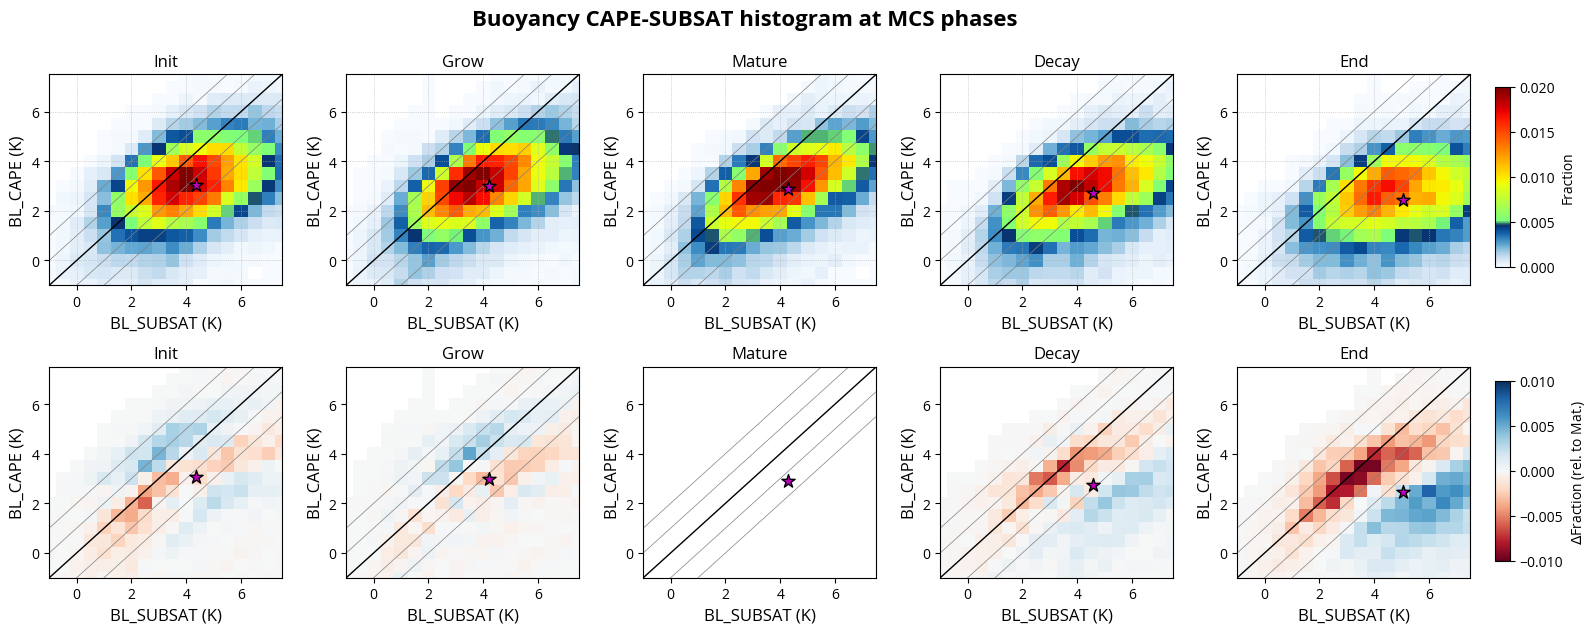

In [20]:
# read written output
data_bins = xr.open_dataset(dir_out /  'mcs_cape_subsat_histogram_IndoPacific.nc')
bins_cape = data_bins.bins_cape
bins_subsat = data_bins.bins_subsat
bins_sample = data_bins.samples.values

# plot histogram : fraction of occurrences at different MCS phases

fig, ((ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10)) = plt.subplots(2,5,figsize=(15,6))

for n, (mcs_phase,ax) in enumerate(zip(['Init','Grow','Mature','Decay','End'],[ax1,ax2,ax3,ax4,ax5])):
    
    tmp = bins_samples[n,:,:]/np.sum(bins_samples[n,:,:])
    tmp[tmp == 0] = np.nan
    
    cp = ax.pcolormesh(bins_subsat, bins_cape, tmp,
                    vmin=0, vmax=0.02, cmap=mixedmap)
    if n == 4:
        caxes = fig.add_axes([1, 0.62, 0.01, 0.3])
        cbar = plt.colorbar(cp, cax=caxes)
        cbar.set_label('Fraction')
    ax.set_title(mcs_phase)
    ax.set_xlabel('BL_SUBSAT (K)',fontsize=12)
    ax.set_ylabel('BL_CAPE (K)',fontsize=12)    
    ax.set_ylim([-1, 7.5])
    ax.set_xlim([-1, 7.5])
    
    # buoyancy reference lines
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13), marker=None, color='k',zorder=2, linewidth=1) # zero buoyancy
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+2, marker=None, color='grey',zorder=2, linewidth=0.5) # +2 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+1, marker=None, color='grey',zorder=2, linewidth=0.5) # +1 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-1, marker=None, color='grey',zorder=2, linewidth=0.5) # -1 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-2, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 

    ax.grid(linestyle=':', linewidth=0.5)
    
    # plot mean states of BL_CAPE and BL_SUBSAT
    mean_cape = np.sum(bins_cape*(np.sum(bins_samples[n,:,:],axis=1)/np.sum(bins_samples[n,:,:])))
    mean_subsat = np.sum(bins_subsat*(np.sum(bins_samples[n,:,:],axis=0)/np.sum(bins_samples[n,:,:])))
    ax.scatter(mean_subsat, mean_cape, s=100, marker='*', color='m', zorder=2, edgecolor='k')

for n, (mcs_phase,ax) in enumerate(zip(['Init','Grow','Mature','Decay','End'],[ax6,ax7,ax8,ax9,ax10])):
    
    tmp = bins_samples[n,:,:]/np.sum(bins_samples[n,:,:]) - bins_samples[2,:,:]/np.sum(bins_samples[2,:,:])
    tmp[tmp == 0] = np.nan
    
    cp = ax.pcolormesh(bins_subsat, bins_cape, tmp,
                    vmin=-0.01, vmax=0.01, cmap='RdBu')
    if n == 4:
        caxes = fig.add_axes([1, 0.13, 0.01, 0.3])
        cbar = plt.colorbar(cp, cax=caxes)
        cbar.set_label('$\Delta$Fraction (rel. to Mat.)')
    ax.set_title(mcs_phase)
    ax.set_xlabel('BL_SUBSAT (K)',fontsize=12)
    ax.set_ylabel('BL_CAPE (K)',fontsize=12)
    ax.set_ylim([-1, 7.5])
    ax.set_xlim([-1, 7.5])
    
    # buoyancy reference lines
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13), marker=None, color='k',zorder=2, linewidth=1) # zero buoyancy
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+2, marker=None, color='grey',zorder=2, linewidth=0.5) # +2 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+1, marker=None, color='grey',zorder=2, linewidth=0.5) # +1 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-1, marker=None, color='grey',zorder=2, linewidth=0.5) # -1 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-2, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 

    # plot mean states of BL_CAPE and BL_SUBSAT
    mean_cape = np.sum(bins_cape*(np.sum(bins_samples[n,:,:],axis=1)/np.sum(bins_samples[n,:,:])))
    mean_subsat = np.sum(bins_subsat*(np.sum(bins_samples[n,:,:],axis=0)/np.sum(bins_samples[n,:,:])))
    ax.scatter(mean_subsat, mean_cape, s=100, marker='*', color='m', zorder=2, edgecolor='k')
    
plt.tight_layout()
plt.suptitle('Buoyancy CAPE-SUBSAT histogram at MCS phases', fontsize=16, fontweight='bold', y=1.05)

In [ ]:
# plot composite evolution of total rain (GPM, ERA-5)
mean_subsat